<a href="https://colab.research.google.com/github/AmeerAliSaleem/MA4J5_Project/blob/main/Ameer_Ali_Saleem_MA4J5_Main_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MA4J5 Project: Predicting Amazon Review Scores with neural networks
---
### Ameer Ali Saleem

A Python notebook containing the Python code to support my MA4J5 report. Please note that this notebook has been written in Google Colab: this allows for the use of the TensorFlow package without requiring a direct installation (which would take roughly 1.1GB of storage). If you do not have TensorFlow installed, please click on the "Open in Colab" link at the top of the notebook.

# Imports and checks

In [1]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import regex as re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
os.environ['PYTHONHASHSEED'] = '0'

# Set seed for neural networks
# This will ensure that we yield the same network initialisation every time we run the code
np.random.seed(8)
random.seed(8)
tf.random.set_seed(8)

# from keras import backend as K

# force TensorFlow to use a single thread
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

In [3]:
# set plotting background style
sns.set()

Our goal is to build a neural network to predict the rating (out of 5 stars) of an input Amazon Kindle review. The data used in this project can be found at <a href="https://nijianmo.github.io/amazon/index.html">this link</a>. In this notebook, we use the undersampled dataset, which should help alleviate the issue of class imbalance.

In [4]:
df = pd.read_csv("kindle_balanced.csv")

In [5]:
df.head()

,overall,reviewTime,reviewText,summary
0,1.0,"05 6, 2016",This reading did not have any real imagination...,This reading did not have any real imagination...
1,4.0,"05 19, 2013","This is a good read,I just wish we would get m...",good read
2,1.0,"09 16, 2016",Really?,One Star
3,3.0,"12 5, 2014",I thought the book was kind of disjointed. It...,"The book had a good story, but just a confusin..."
4,1.0,"04 29, 2015",Really a waste of time. Horribly boring.,Save your time...not worth it.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181465 entries, 0 to 181464
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     181465 non-null  float64
 1   reviewTime  181465 non-null  object 
 2   reviewText  181432 non-null  object 
 3   summary     181401 non-null  object 
dtypes: float64(1), object(3)
memory usage: 5.5+ MB


In [7]:
len(df)

181465

In [8]:
df['overall'].value_counts()

1.0    36293
4.0    36293
3.0    36293
2.0    36293
5.0    36293
Name: overall, dtype: int64

In [9]:
df[df['overall'] == 1]['reviewText'][:10]

0     This reading did not have any real imagination...
2                                               Really?
4              Really a waste of time. Horribly boring.
10                        Lost interest never finished.
25    This gets only one star because there is no my...
35    The book opens to a female vampire leaving the...
38    I don't know if the previous reviewers actuall...
44    I was embarrassed reading this. not work money...
58    This is a book of completely made up animal na...
61    I'm sorry but i stopped mid way through the 3r...
Name: reviewText, dtype: object

# Text Preprocessing

In [10]:
type(df["reviewText"].values)

numpy.ndarray

In [11]:
print(type(df["reviewText"].iloc[0]))

<class 'str'>


In [12]:
df["reviewText"] = df["reviewText"].astype(str)

In [13]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
# custom stopwords
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such']

In [15]:
reviews_cleaned = []

for i in range(len(df["reviewText"])):
  reviews_raw = df["reviewText"].iloc[i]
  reviews_edit_1 = reviews_raw.lower()
  reviews_edit_2 = re.sub(r"[^a-zA-Z0-9\s\.]", "", reviews_edit_1) # Filter punctuation
  # reviews_edit_3 = re.sub(" \.|\. ", "", reviews_edit_2) # Get rid of fullstops that are outside of words
  reviews_cleaned.append(reviews_edit_2.strip()) # remove unnecessary whitespace and append to list of cleaned reviews


# vectorised code
# reviews_edit_1 = df["reviewText"].str.lower() # Convert all reviewText to lowercase
# reviews_edit_2 = reviews_edit_1.str.replace(r"[^a-zA-Z0-9\s\.]", "") # Filter that punctuation g
# reviews_cleaned = reviews_edit_2.str.strip().tolist() # Remove unnecessary whitespace

In [16]:
# remove stopwords from the cleaned list
filtered_reviews = [
    ' '.join(word for word in sentence.split() if word.lower() not in stopwords)
    for sentence in reviews_cleaned
]

In [17]:
# compare first record vs record with stopwords removed
print(reviews_cleaned[0])
print(filtered_reviews[0])

this reading did not have any real imagination in it.  i really could not see the point the story was trying to make.
reading not real imagination it. really could not see point story trying make.


In [18]:
# observe first five filtered reviews + scores
for i in range(5):
  print(filtered_reviews[i])
  print(df["overall"][i])

reading not real imagination it. really could not see point story trying make.
1.0
good readi just wish would get information mystery bernie. soon would good.
4.0
really
1.0
thought book kind disjointed. seems chapter left hanging without explanation. never really explain relationship mother lord froste helping book good story just confusing way get there.
3.0
really waste time. horribly boring.
1.0


## Train-test split

We shift the scores from (1,2,3,4,5) to (0,1,2,3,4) to help with network analysis later.

In [19]:
df['overall'] = df['overall'] - 1

In [20]:
labels = list(df["overall"])

# Shuffle the data.

filtered_reviews, labels = zip(*random.sample(list(zip(filtered_reviews,labels)), len(filtered_reviews)))
filtered_reviews = list(filtered_reviews)
labels = list(labels)

# Train-test split (66:33)

trainsize = int(len(filtered_reviews)*0.66)

train_reviews, train_labels = filtered_reviews[:trainsize], labels[:trainsize]
test_reviews, test_labels = filtered_reviews[trainsize:], labels[trainsize:]

In [21]:
# Check distribution reviews (1,2,3,4,5) in the training set

print("TRAINING SET")
print("Number of reviews to use for training is: {}.".format(len(train_labels)))
print("Number of 5-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==4),100*sum(np.array(train_labels)==4)/len(train_labels)))
print("Number of 4-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==3),100*sum(np.array(train_labels)==3)/len(train_labels)))
print("Number of 3-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==2),100*sum(np.array(train_labels)==2)/len(train_labels)))
print("Number of 2-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==1),100*sum(np.array(train_labels)==1)/len(train_labels)))
print("Number of 1-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==0),100*sum(np.array(train_labels)==0)/len(train_labels)))

TRAINING SET
Number of reviews to use for training is: 119766.
Number of 5-star reviews is: 23809 (or 19.9%).
Number of 4-star reviews is: 24114 (or 20.1%).
Number of 3-star reviews is: 23961 (or 20.0%).
Number of 2-star reviews is: 23848 (or 19.9%).
Number of 1-star reviews is: 24034 (or 20.1%).


## Tokenisation

The word tokenizer provided by the Keras package will be able to deal with full stops for us, e.g. "missing." and "missing" will be treated as the same token.

Now for the tokenisation. In particular, we must conduct this separately on the training and test sets. The reason for this is due to so-called "data leakage": we do not want to introduce any elements of the testing data to the network before or during training. These two sets should be kept as separate as possible.

In [22]:
# max size of our vectorised corpus
vocab_size = 20000

# maximum allowed length for each vectorised sentence into our neural network
max_length = 50

# Tokenization
# OOV token deals with words that our tokenizer has not seen before (e.g. in the test set)
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_reviews)
word_index = tokenizer.word_index

# print out our dictionary of vectors
# print(word_index)


train_sequences = tokenizer.texts_to_sequences(train_reviews)
test_sequences = tokenizer.texts_to_sequences(test_reviews)

# padding sequences to standardise the input size of each row of data for our NN
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

In [23]:
print(type(train_labels[0]))

train_labels_int = [int(x) for x in train_labels]
test_labels_int = [int(x) for x in test_labels]

print(type(train_labels_int[0]))

<class 'float'>
<class 'int'>


In [24]:
print(len(word_index))

94557


# Model Building and Evaluation

We now experiment with a variety of neural network architectures, with the aim of maximising the accuracy of our model on the *testing set*.

In [25]:
# function to plot and analyse the learning of each neural network
def learning_curve(history):
    plt.figure(figsize=(10,12))

    # Loss subplot.
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Testing loss')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy subplot.
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [26]:
# more model parameters
embedding_dim = 16
num_epochs = 15
batch_size = 1000

###Experimenting with activation layers [pooling]
---

In [ ]:
def pooling(embedding_dim, num_epochs, batch_size, activation_func):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation=activation_func),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  model.summary()

  history = model.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

  learning_curve(history)

  return history

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 50, 32)            640000    
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
 5 (GlobalAveragePooling1D)                                      
                                                                 
 dense_39 (Dense)            (None, 16)                528       
                                                                 
 dense_40 (Dense)            (None, 5)                 85        
                                                                 
Total params: 640613 (2.44 MB)
Trainable params: 640613 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 2s - loss: 1.2200 - accuracy: 0.2681 - val_loss: 1.1391 - val_

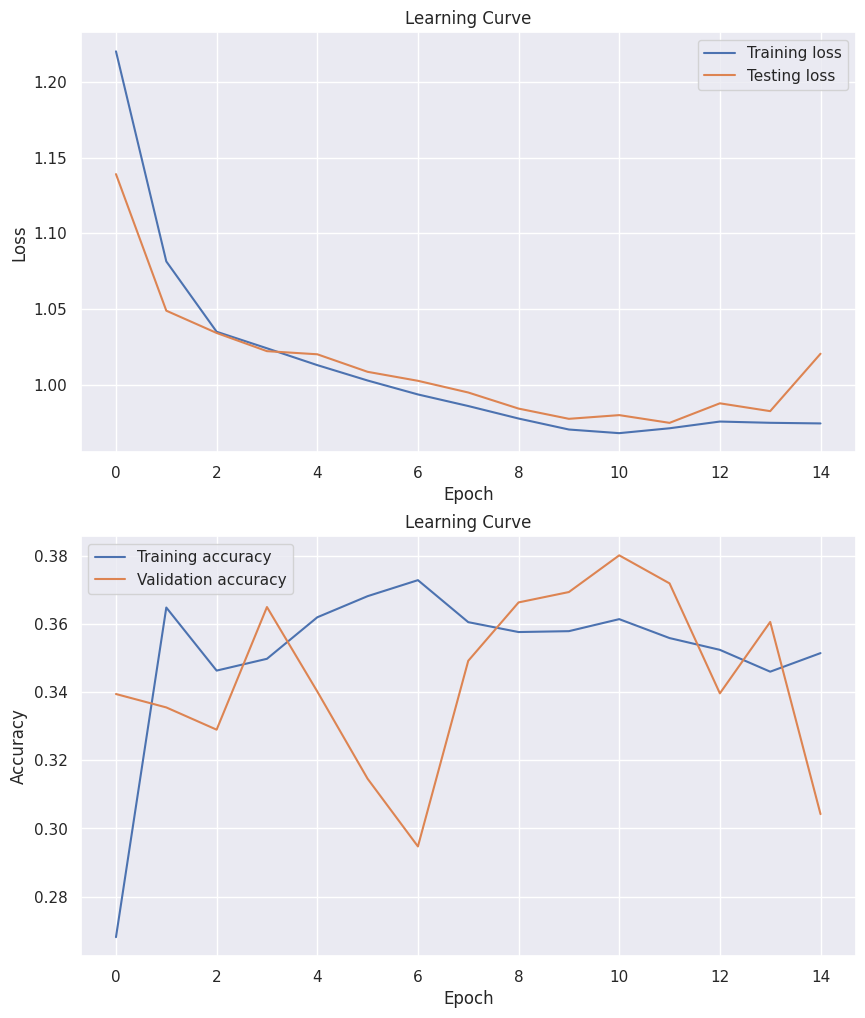

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_pooling_1 = pooling(embedding_dim, num_epochs, batch_size, 'relu')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 32)            640000    
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 640613 (2.44 MB)
Trainable params: 640613 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 2s - loss: 1.1830 - accuracy: 0.2134 - val_loss: 1.1535 - val_a

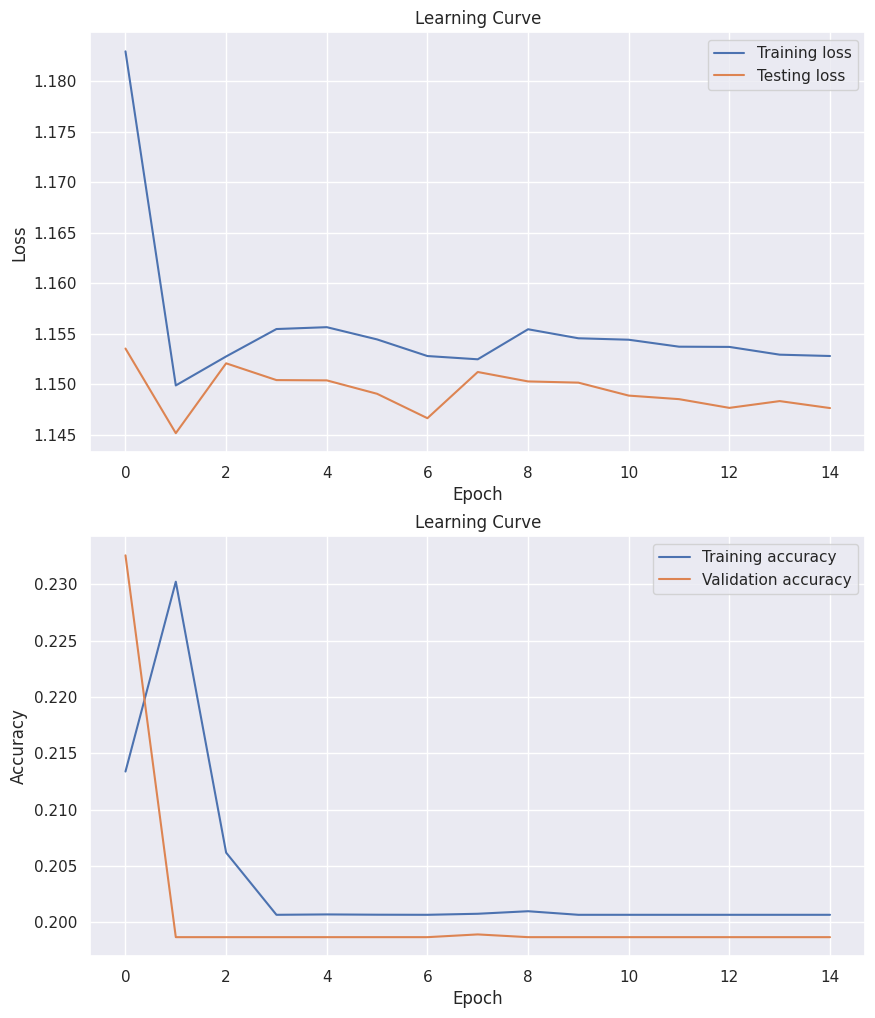

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_pooling_2 = pooling(embedding_dim, num_epochs, batch_size, 'sigmoid')

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 50, 32)            640000    
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
 6 (GlobalAveragePooling1D)                                      
                                                                 
 dense_41 (Dense)            (None, 16)                528       
                                                                 
 dense_42 (Dense)            (None, 5)                 85        
                                                                 
Total params: 640613 (2.44 MB)
Trainable params: 640613 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 2s - loss: 1.2714 - accuracy: 0.1988 - val_loss: 1.2468 - val_

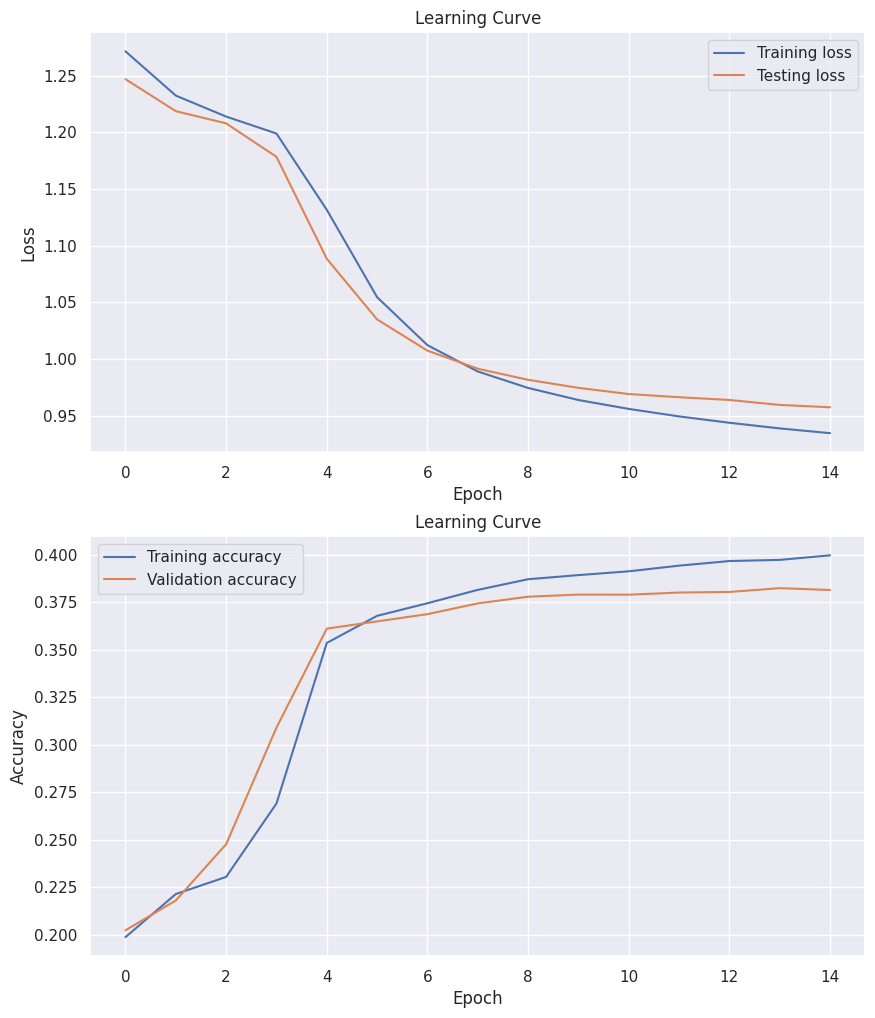

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_pooling_3 = pooling(embedding_dim, num_epochs, batch_size, 'softmax')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 32)            640000    
                                                                 
 global_average_pooling1d_3  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 5)                 85        
                                                                 
Total params: 640613 (2.44 MB)
Trainable params: 640613 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 2s - loss: 1.1968 - accuracy: 0.2788 - val_loss: 1.1175 - val_a

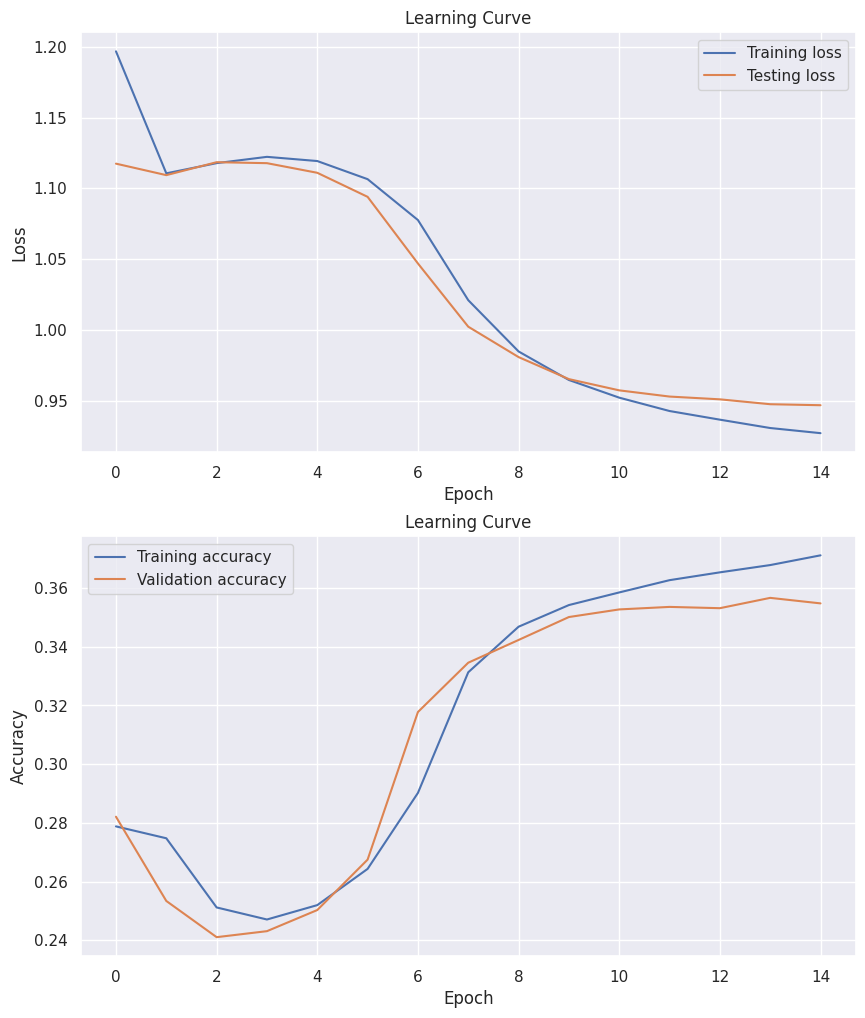

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_pooling_4 = pooling(embedding_dim, num_epochs, batch_size, 'tanh')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 32)            640000    
                                                                 
 global_average_pooling1d_4  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 5)                 85        
                                                                 
Total params: 640613 (2.44 MB)
Trainable params: 640613 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 2s - loss: 1.2023 - accuracy: 0.2157 - val_loss: 1.1260 - val_a

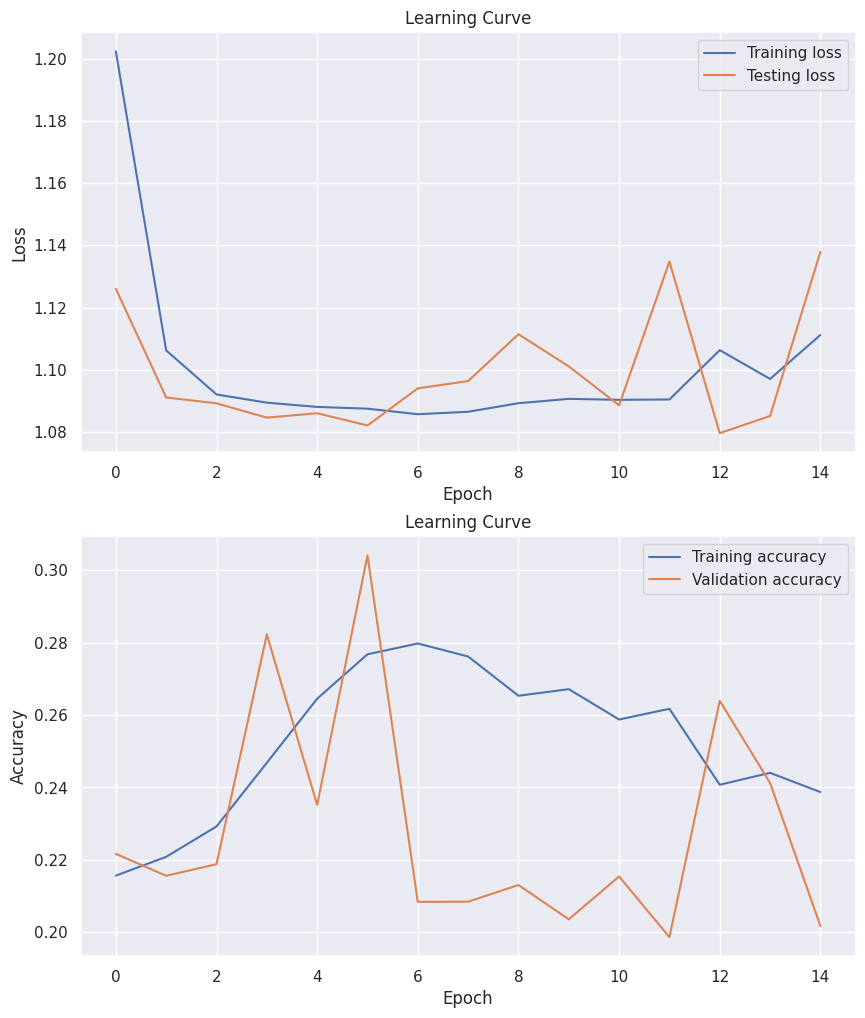

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_pooling_5 = pooling(embedding_dim, num_epochs, batch_size, 'leaky_relu')

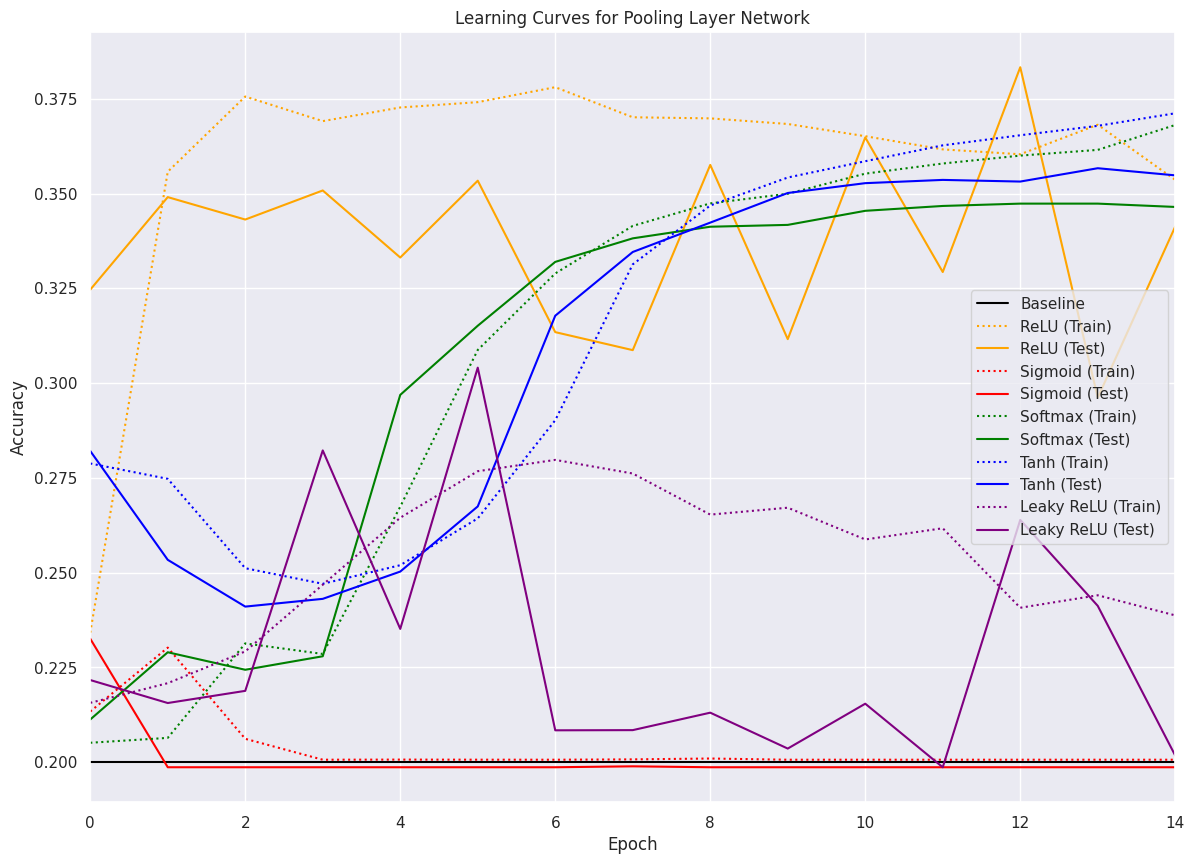

In [ ]:
# Plot all five learning curves on the same axes.
plt.figure(figsize=(14,10))
sns.set()

plt.axhline(0.2, label='Baseline', color='black')
plt.plot(history_pooling_1.history['accuracy'], label='ReLU (Train)', color='orange', linestyle='dotted')
plt.plot(history_pooling_1.history['val_accuracy'], label='ReLU (Test)', color='orange')
plt.plot(history_pooling_2.history['accuracy'], label='Sigmoid (Train)', color='red', linestyle='dotted')
plt.plot(history_pooling_2.history['val_accuracy'], label='Sigmoid (Test)', color='red')
plt.plot(history_pooling_3.history['accuracy'], label='Softmax (Train)', color='green', linestyle='dotted')
plt.plot(history_pooling_3.history['val_accuracy'], label='Softmax (Test)', color='green')
plt.plot(history_pooling_4.history['accuracy'], label='Tanh (Train)', color='blue', linestyle='dotted')
plt.plot(history_pooling_4.history['val_accuracy'], label='Tanh (Test)', color='blue')
plt.plot(history_pooling_5.history['accuracy'], label='Leaky ReLU (Train)', color='purple', linestyle='dotted')
plt.plot(history_pooling_5.history['val_accuracy'], label='Leaky ReLU (Test)', color='purple')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0,14)
# plt.ylim((0.2,0.8))
plt.title('Learning Curves for Pooling Layer Network')

plt.show()

### Experimenting with activation layers [flatten]
---

In [ ]:
def flatten(embedding_dim, num_epochs, batch_size, activation_func):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation=activation_func),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  model.summary()

  history = model.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

  learning_curve(history)

  return history

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 32)            640000    
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_10 (Dense)            (None, 16)                25616     
                                                                 
 dense_11 (Dense)            (None, 5)                 85        
                                                                 
Total params: 665701 (2.54 MB)
Trainable params: 665701 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 3s - loss: 1.1435 - accuracy: 0.2286 - val_loss: 1.0394 - val_accuracy: 0.2958 - 3s/epoch - 21ms/step
Epoch 2/15
120/120 - 1s - l

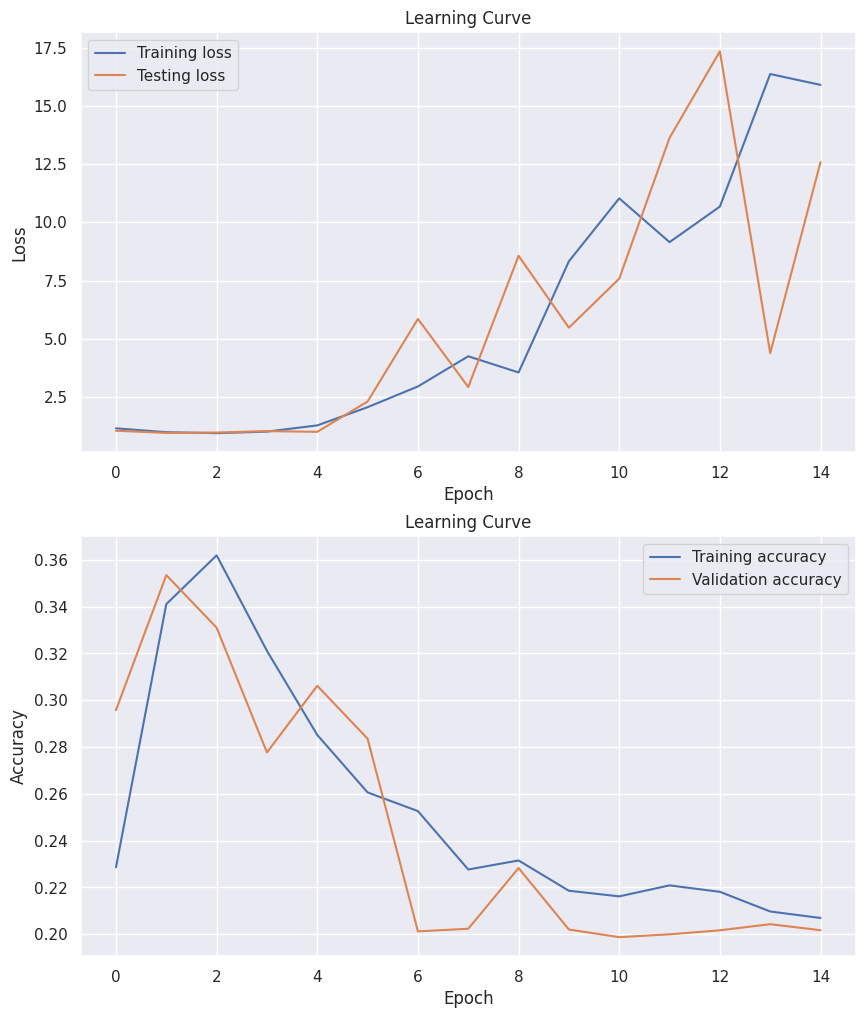

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_flatten_1 = flatten(embedding_dim, num_epochs, batch_size, 'relu')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 32)            640000    
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_12 (Dense)            (None, 16)                25616     
                                                                 
 dense_13 (Dense)            (None, 5)                 85        
                                                                 
Total params: 665701 (2.54 MB)
Trainable params: 665701 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 2s - loss: 1.1995 - accuracy: 0.2107 - val_loss: 1.1527 - val_accuracy: 0.2058 - 2s/epoch - 18ms/step
Epoch 2/15
120/120 - 2s - l

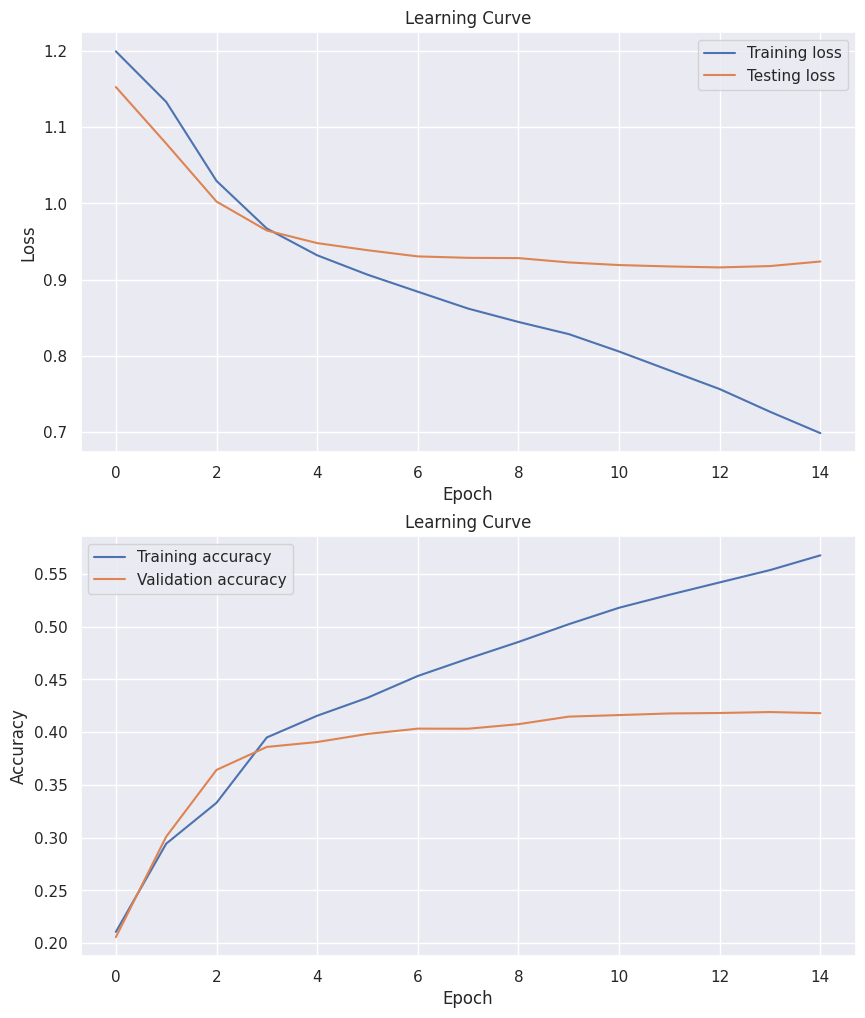

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_flatten_2 = flatten(embedding_dim, num_epochs, batch_size, 'sigmoid')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 32)            640000    
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_14 (Dense)            (None, 16)                25616     
                                                                 
 dense_15 (Dense)            (None, 5)                 85        
                                                                 
Total params: 665701 (2.54 MB)
Trainable params: 665701 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 2s - loss: 1.2513 - accuracy: 0.2040 - val_loss: 1.2375 - val_accuracy: 0.2056 - 2s/epoch - 19ms/step
Epoch 2/15
120/120 - 2s - l

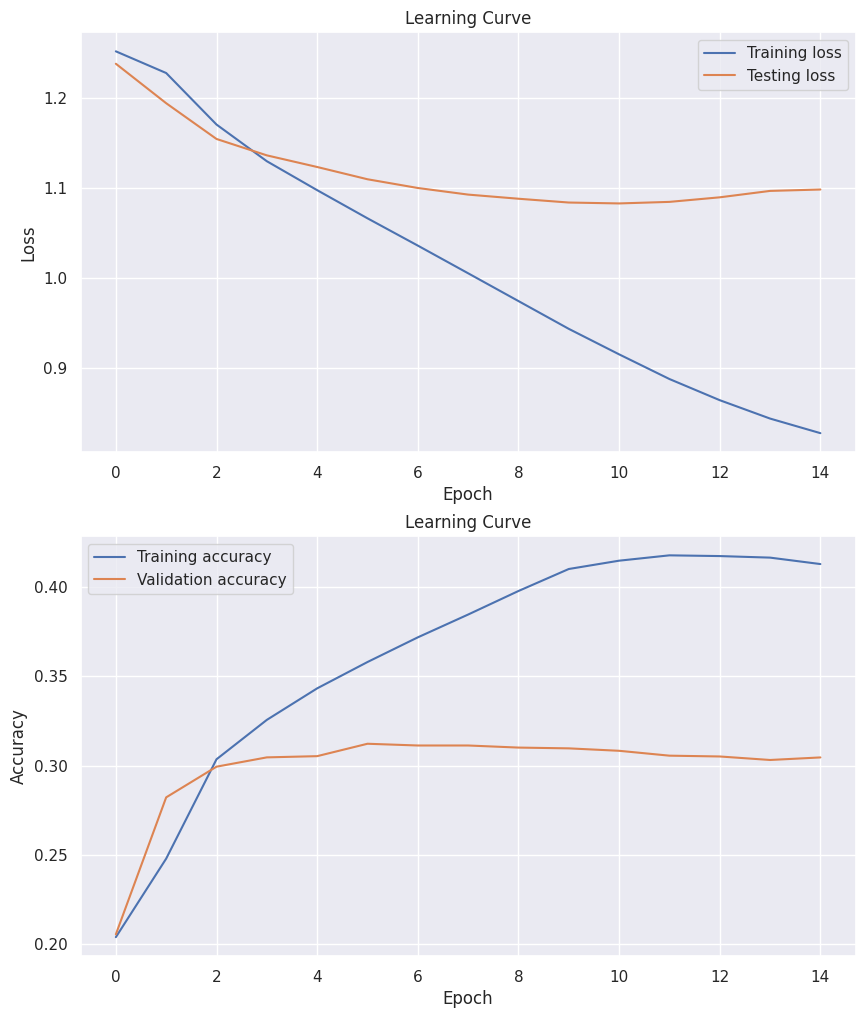

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_flatten_3 = flatten(embedding_dim, num_epochs, batch_size, 'softmax')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 32)            640000    
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_16 (Dense)            (None, 16)                25616     
                                                                 
 dense_17 (Dense)            (None, 5)                 85        
                                                                 
Total params: 665701 (2.54 MB)
Trainable params: 665701 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 2s - loss: 1.1467 - accuracy: 0.2274 - val_loss: 1.0940 - val_accuracy: 0.2928 - 2s/epoch - 18ms/step
Epoch 2/15
120/120 - 1s - l

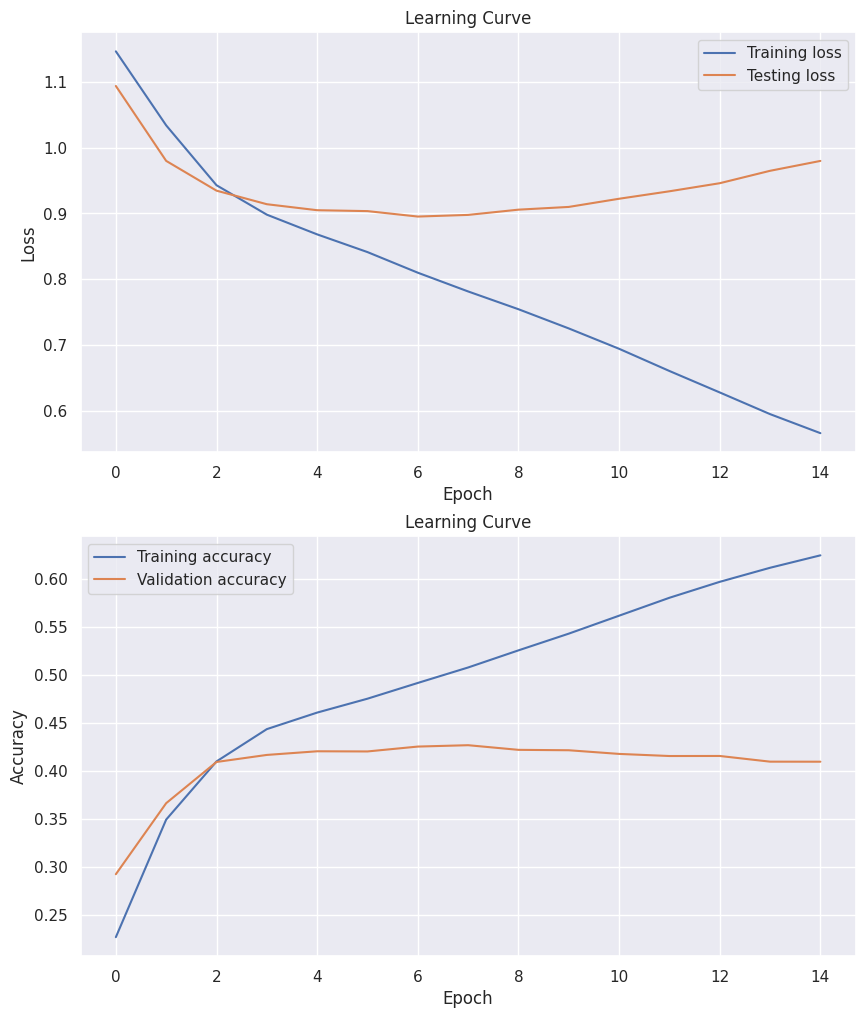

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_flatten_4 = flatten(embedding_dim, num_epochs, batch_size, 'tanh')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 32)            640000    
                                                                 
 flatten_4 (Flatten)         (None, 1600)              0         
                                                                 
 dense_18 (Dense)            (None, 16)                25616     
                                                                 
 dense_19 (Dense)            (None, 5)                 85        
                                                                 
Total params: 665701 (2.54 MB)
Trainable params: 665701 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 2s - loss: 1.1401 - accuracy: 0.2309 - val_loss: 1.0966 - val_accuracy: 0.2790 - 2s/epoch - 18ms/step
Epoch 2/15
120/120 - 1s - l

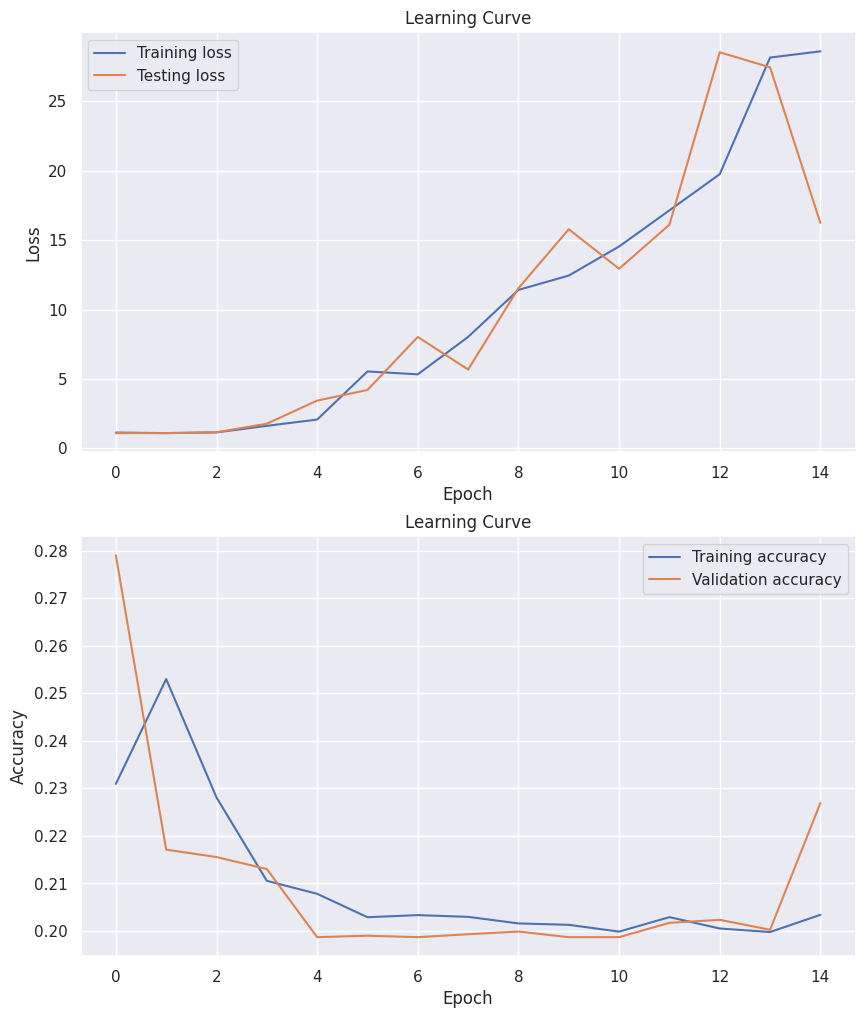

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_flatten_5 = flatten(embedding_dim, num_epochs, batch_size, 'leaky_relu')

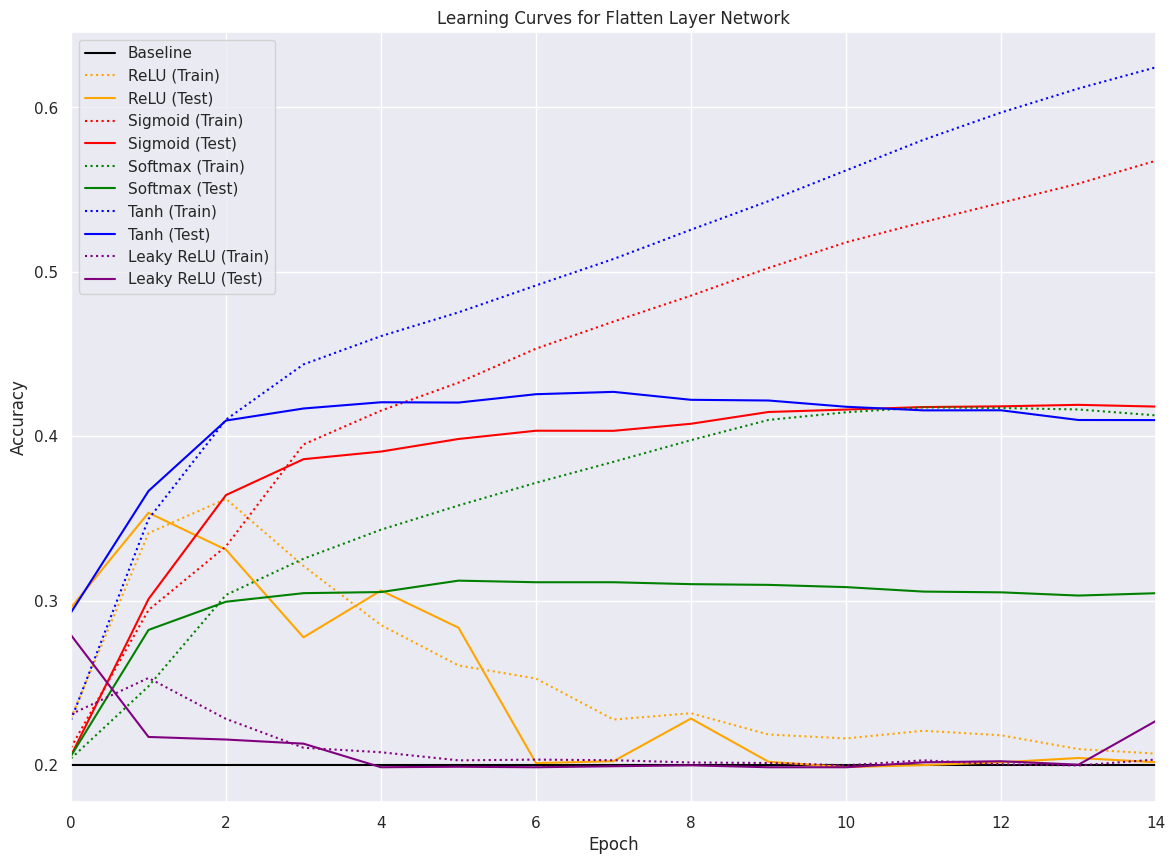

In [ ]:
# Plot all five learning curves on the same axes.
plt.figure(figsize=(14,10))
sns.set()

plt.axhline(0.2, label='Baseline', color='black')
plt.plot(history_flatten_1.history['accuracy'], label='ReLU (Train)', color='orange', linestyle='dotted')
plt.plot(history_flatten_1.history['val_accuracy'], label='ReLU (Test)', color='orange')
plt.plot(history_flatten_2.history['accuracy'], label='Sigmoid (Train)', color='red', linestyle='dotted')
plt.plot(history_flatten_2.history['val_accuracy'], label='Sigmoid (Test)', color='red')
plt.plot(history_flatten_3.history['accuracy'], label='Softmax (Train)', color='green', linestyle='dotted')
plt.plot(history_flatten_3.history['val_accuracy'], label='Softmax (Test)', color='green')
plt.plot(history_flatten_4.history['accuracy'], label='Tanh (Train)', color='blue', linestyle='dotted')
plt.plot(history_flatten_4.history['val_accuracy'], label='Tanh (Test)', color='blue')
plt.plot(history_flatten_5.history['accuracy'], label='Leaky ReLU (Train)', color='purple', linestyle='dotted')
plt.plot(history_flatten_5.history['val_accuracy'], label='Leaky ReLU (Test)', color='purple')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0,14)
# plt.ylim((0.2,0.8))
plt.title('Learning Curves for Flatten Layer Network')

plt.show()

### Experimenting with activation layers [convolution layer]
---

In [ ]:
def convolution(embedding_dim, num_epochs, batch_size, activation_func):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation=activation_func),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  model.summary()

  history = model.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

  learning_curve(history)

  return history

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 50, 32)            640000    
                                                                 
 conv1d (Conv1D)             (None, 46, 128)           20608     
                                                                 
 global_average_pooling1d_5  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_20 (Dense)            (None, 5)                 645       
                                                                 
Total params: 661253 (2.52 MB)
Trainable params: 661253 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 14s - loss: 1.1470 - accuracy: 0.2079 - val_loss: 1.1007 - val

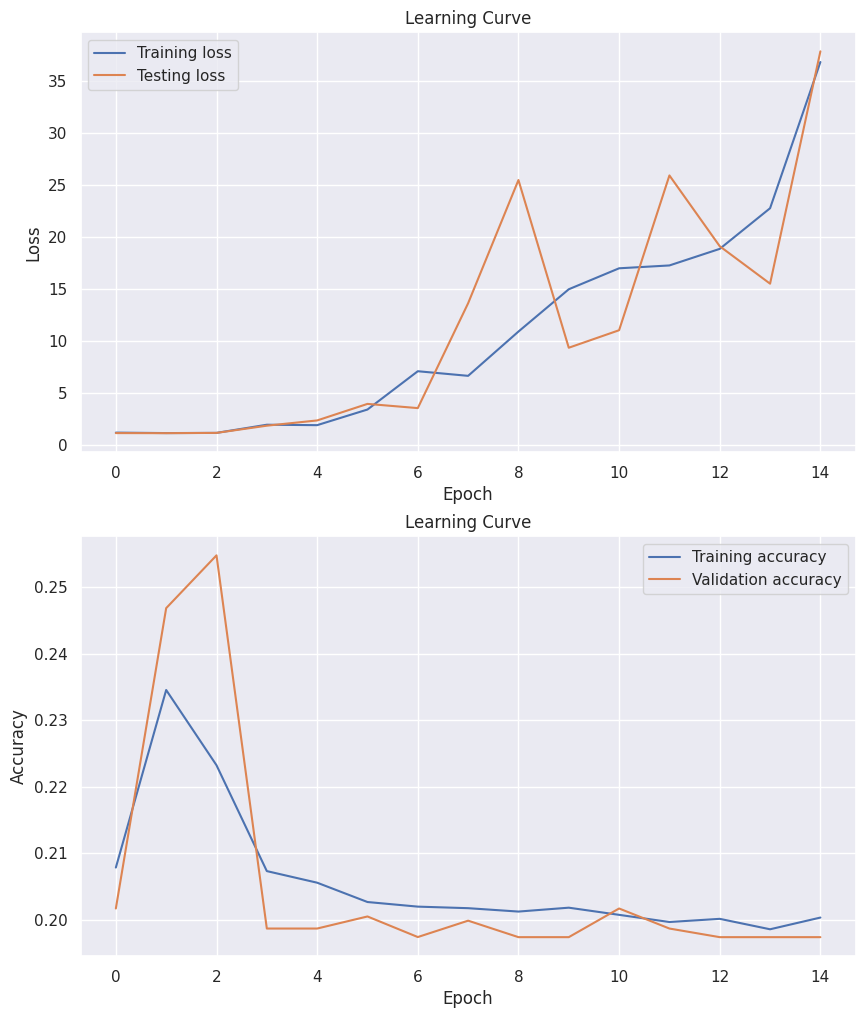

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_conv_1 = convolution(embedding_dim, num_epochs, batch_size, 'relu')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 50, 32)            640000    
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 128)           20608     
                                                                 
 global_average_pooling1d_6  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_21 (Dense)            (None, 5)                 645       
                                                                 
Total params: 661253 (2.52 MB)
Trainable params: 661253 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 15s - loss: 1.1812 - accuracy: 0.2084 - val_loss: 1.1532 - val

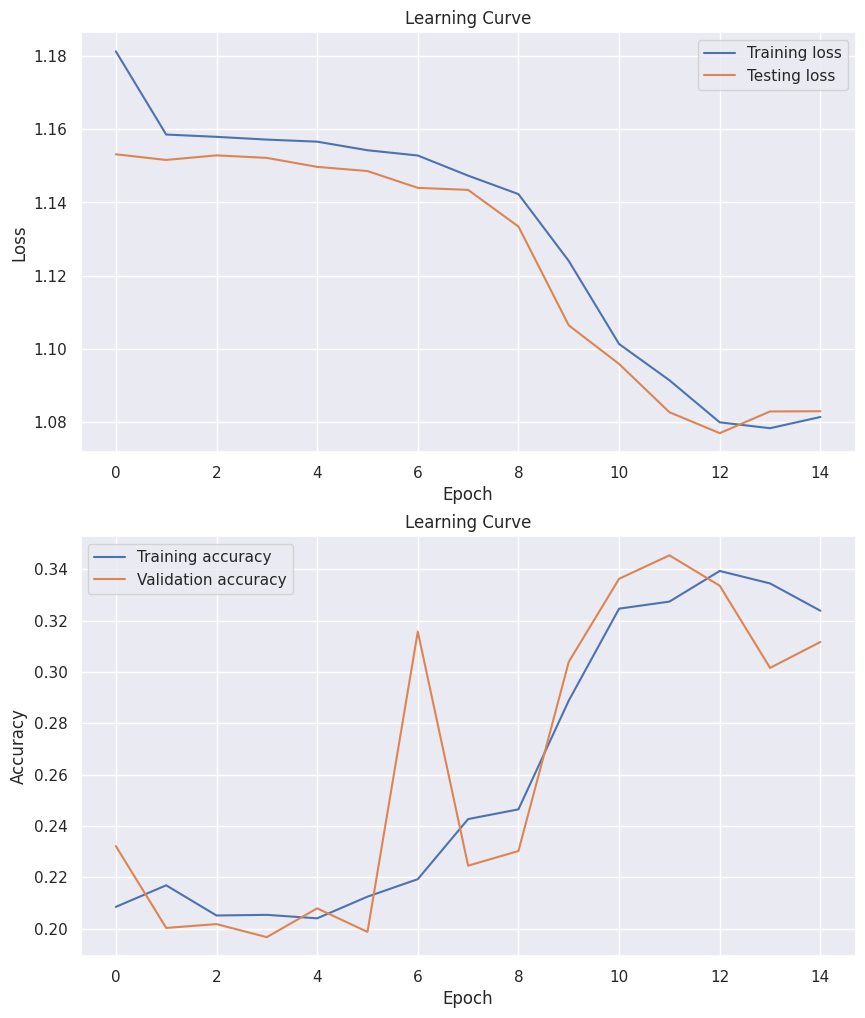

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_conv_2 = convolution(embedding_dim, num_epochs, batch_size, 'sigmoid')

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 50, 32)            640000    
                                                                 
 conv1d_2 (Conv1D)           (None, 46, 128)           20608     
                                                                 
 global_average_pooling1d_7  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_22 (Dense)            (None, 5)                 645       
                                                                 
Total params: 661253 (2.52 MB)
Trainable params: 661253 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 16s - loss: 1.2682 - accuracy: 0.1993 - val_loss: 1.2416 - val

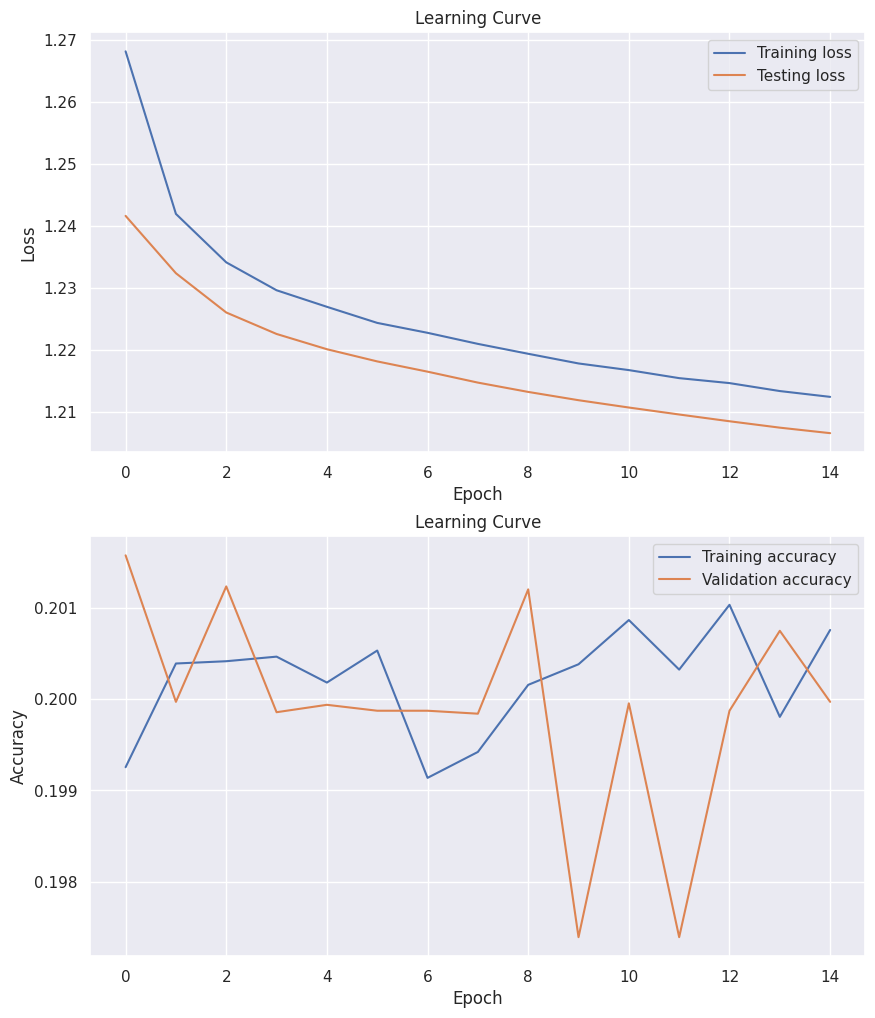

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_conv_3 = convolution(embedding_dim, num_epochs, batch_size, 'softmax')

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 50, 32)            640000    
                                                                 
 conv1d_3 (Conv1D)           (None, 46, 128)           20608     
                                                                 
 global_average_pooling1d_8  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_23 (Dense)            (None, 5)                 645       
                                                                 
Total params: 661253 (2.52 MB)
Trainable params: 661253 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 14s - loss: 1.1413 - accuracy: 0.2161 - val_loss: 1.1152 - val

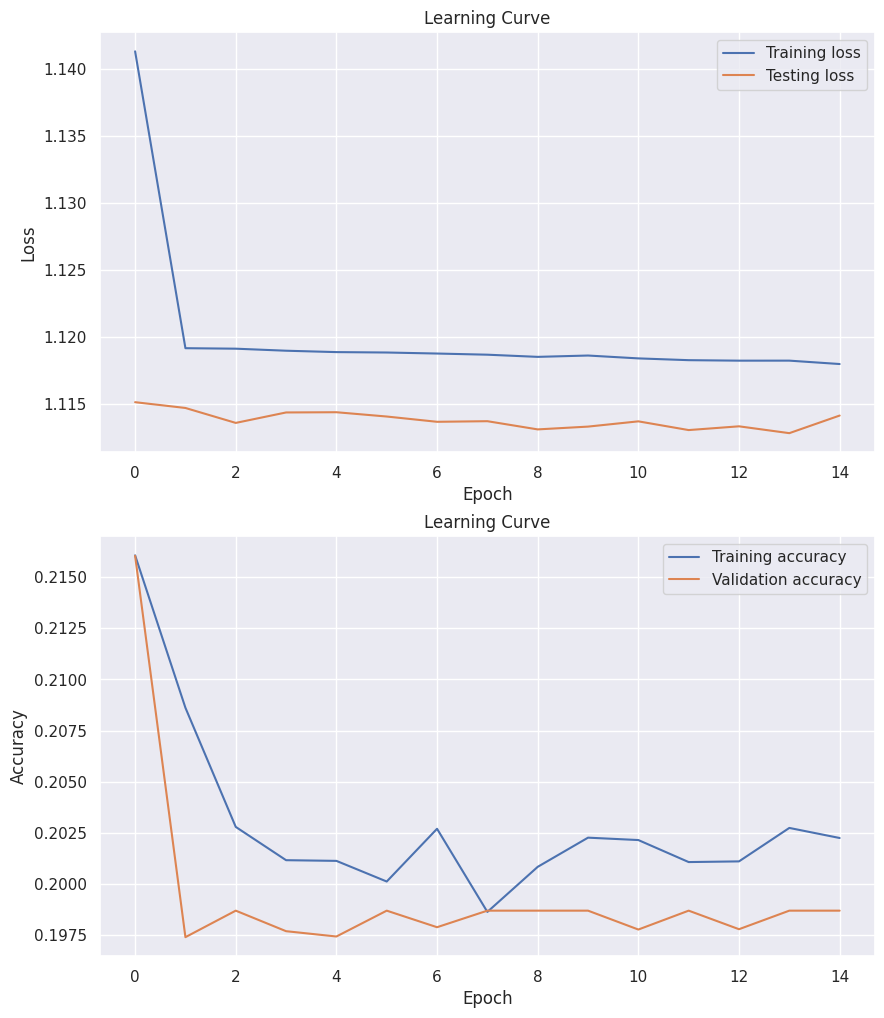

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_conv_4 = convolution(embedding_dim, num_epochs, batch_size, 'tanh')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 50, 32)            640000    
                                                                 
 conv1d_4 (Conv1D)           (None, 46, 128)           20608     
                                                                 
 global_average_pooling1d_9  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_24 (Dense)            (None, 5)                 645       
                                                                 
Total params: 661253 (2.52 MB)
Trainable params: 661253 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 13s - loss: 1.1422 - accuracy: 0.2118 - val_loss: 1.1059 - val

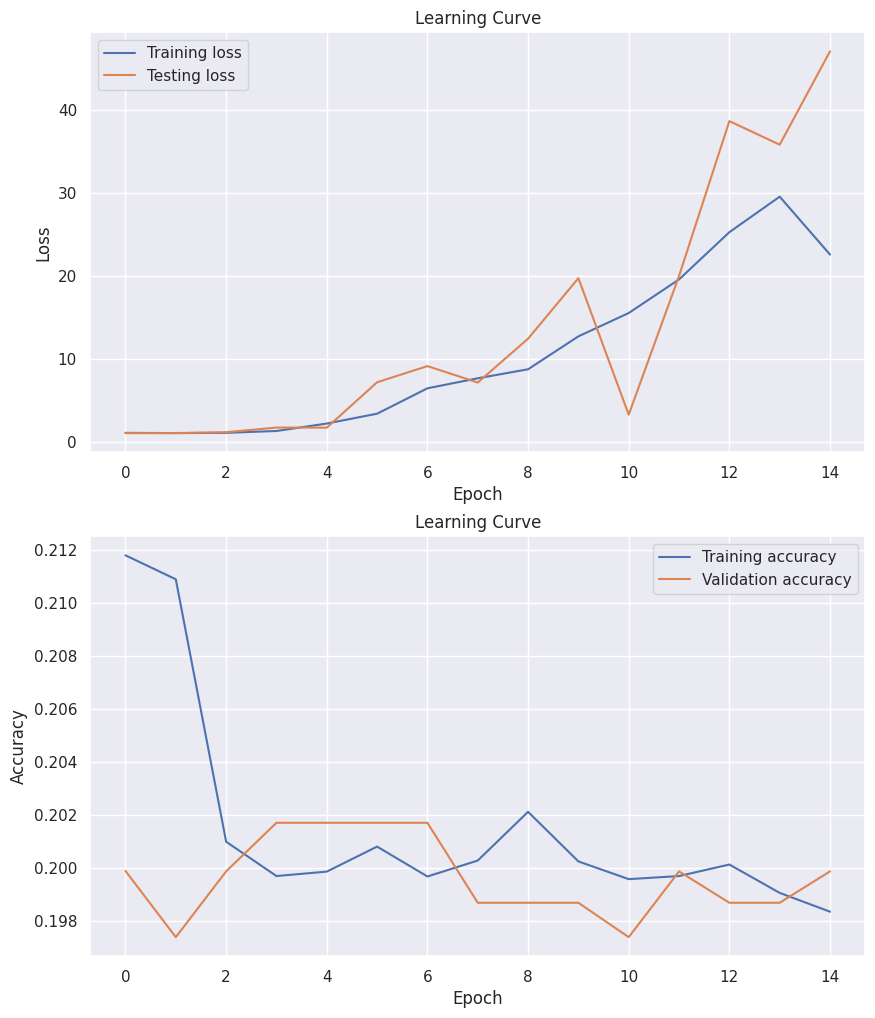

In [ ]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_conv_5 = convolution(embedding_dim, num_epochs, batch_size, 'leaky_relu')

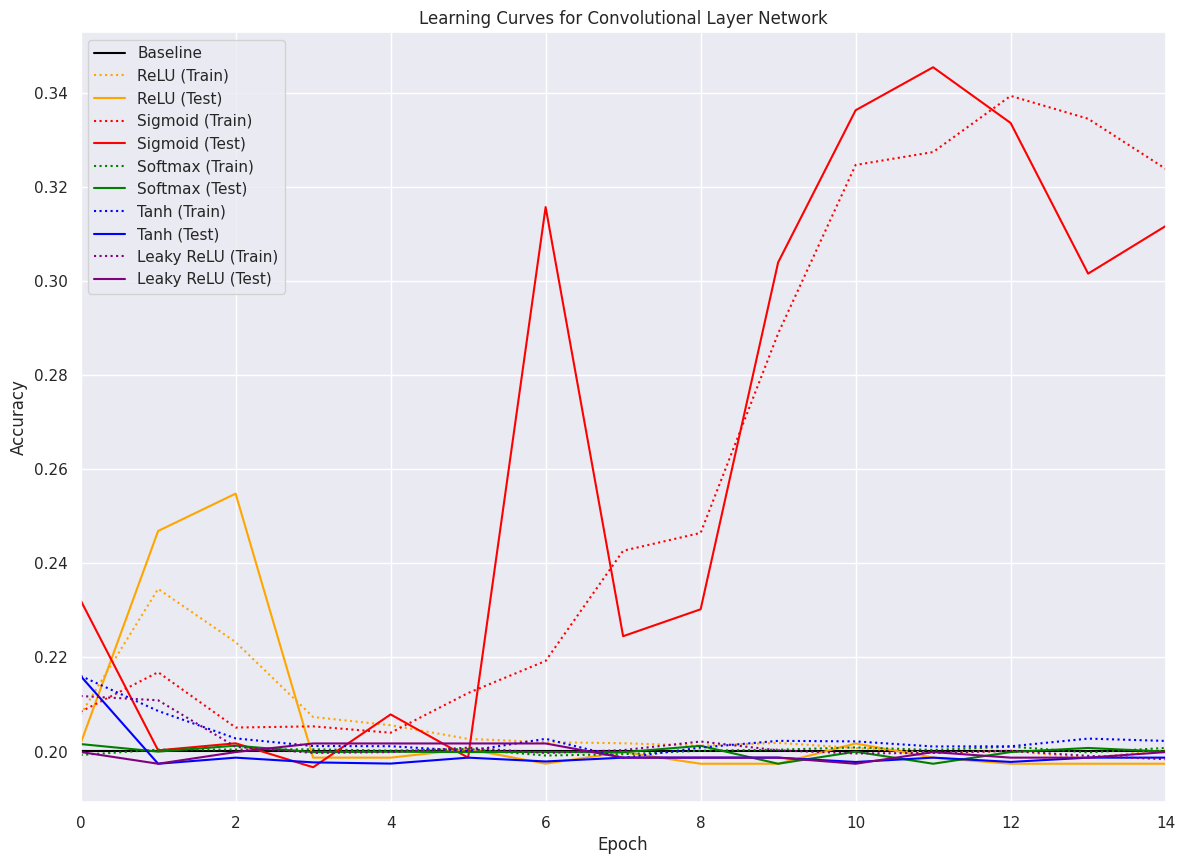

In [ ]:
# Plot all five learning curves on the same axes.
plt.figure(figsize=(14,10))
sns.set()

plt.axhline(0.2, label='Baseline', color='black')
plt.plot(history_conv_1.history['accuracy'], label='ReLU (Train)', color='orange', linestyle='dotted')
plt.plot(history_conv_1.history['val_accuracy'], label='ReLU (Test)', color='orange')
plt.plot(history_conv_2.history['accuracy'], label='Sigmoid (Train)', color='red', linestyle='dotted')
plt.plot(history_conv_2.history['val_accuracy'], label='Sigmoid (Test)', color='red')
plt.plot(history_conv_3.history['accuracy'], label='Softmax (Train)', color='green', linestyle='dotted')
plt.plot(history_conv_3.history['val_accuracy'], label='Softmax (Test)', color='green')
plt.plot(history_conv_4.history['accuracy'], label='Tanh (Train)', color='blue', linestyle='dotted')
plt.plot(history_conv_4.history['val_accuracy'], label='Tanh (Test)', color='blue')
plt.plot(history_conv_5.history['accuracy'], label='Leaky ReLU (Train)', color='purple', linestyle='dotted')
plt.plot(history_conv_5.history['val_accuracy'], label='Leaky ReLU (Test)', color='purple')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0,14)
# plt.ylim((0.2,0.8))
plt.title('Learning Curves for Convolutional Layer Network')

plt.show()

### Experimenting with model architectures
---

In [27]:
# model hyperparameters
embedding_dim = 16
num_epochs = 15
batch_size = 1000

# Average pooling
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(5, activation='softmax')
])
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [28]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            320000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 85        
                                                                 
Total params: 320085 (1.22 MB)
Trainable params: 320085 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
history1 = model1.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

Epoch 1/15
120/120 - 3s - loss: 1.5932 - accuracy: 0.2946 - val_loss: 1.5704 - val_accuracy: 0.3409 - 3s/epoch - 29ms/step
Epoch 2/15
120/120 - 2s - loss: 1.5328 - accuracy: 0.3817 - val_loss: 1.4927 - val_accuracy: 0.4008 - 2s/epoch - 13ms/step
Epoch 3/15
120/120 - 1s - loss: 1.4462 - accuracy: 0.4289 - val_loss: 1.4073 - val_accuracy: 0.4324 - 1s/epoch - 12ms/step
Epoch 4/15
120/120 - 2s - loss: 1.3650 - accuracy: 0.4629 - val_loss: 1.3381 - val_accuracy: 0.4586 - 2s/epoch - 13ms/step
Epoch 5/15
120/120 - 1s - loss: 1.3008 - accuracy: 0.4847 - val_loss: 1.2859 - val_accuracy: 0.4784 - 1s/epoch - 12ms/step
Epoch 6/15
120/120 - 1s - loss: 1.2508 - accuracy: 0.5016 - val_loss: 1.2462 - val_accuracy: 0.4873 - 1s/epoch - 12ms/step
Epoch 7/15
120/120 - 1s - loss: 1.2110 - accuracy: 0.5104 - val_loss: 1.2157 - val_accuracy: 0.4938 - 1s/epoch - 11ms/step
Epoch 8/15
120/120 - 2s - loss: 1.1789 - accuracy: 0.5197 - val_loss: 1.1922 - val_accuracy: 0.4985 - 2s/epoch - 14ms/step
Epoch 9/15
120/1

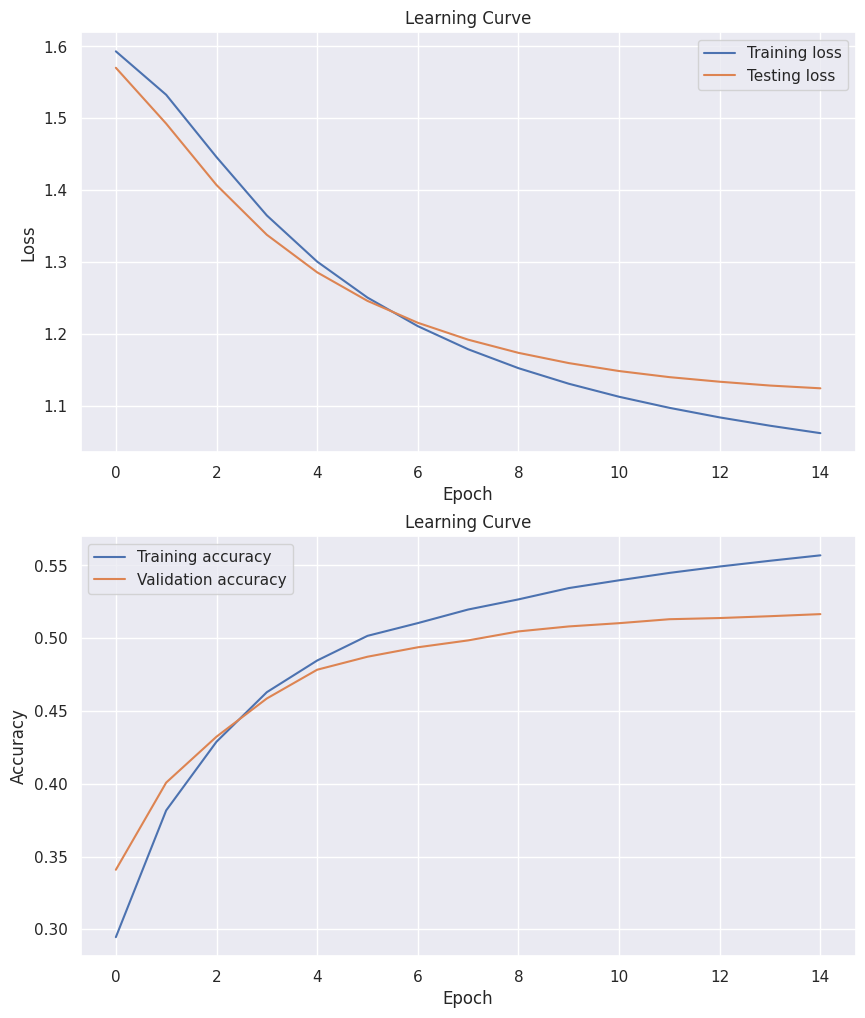

In [30]:
learning_curve(history1)

In [31]:
# model hyperparameters
embedding_dim = 16
num_epochs = 15
batch_size = 1000

# LSTM setup
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [32]:
history2 = model2.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

Epoch 1/15
120/120 - 18s - loss: 1.4862 - accuracy: 0.3570 - val_loss: 1.2359 - val_accuracy: 0.4348 - 18s/epoch - 153ms/step
Epoch 2/15
120/120 - 14s - loss: 1.1359 - accuracy: 0.5087 - val_loss: 1.1287 - val_accuracy: 0.5051 - 14s/epoch - 113ms/step
Epoch 3/15
120/120 - 14s - loss: 1.0502 - accuracy: 0.5478 - val_loss: 1.1185 - val_accuracy: 0.5087 - 14s/epoch - 113ms/step
Epoch 4/15
120/120 - 14s - loss: 1.0095 - accuracy: 0.5700 - val_loss: 1.1248 - val_accuracy: 0.5071 - 14s/epoch - 114ms/step
Epoch 5/15
120/120 - 14s - loss: 0.9806 - accuracy: 0.5852 - val_loss: 1.1373 - val_accuracy: 0.5056 - 14s/epoch - 113ms/step
Epoch 6/15
120/120 - 13s - loss: 0.9566 - accuracy: 0.5993 - val_loss: 1.1510 - val_accuracy: 0.5042 - 13s/epoch - 112ms/step
Epoch 7/15
120/120 - 14s - loss: 0.9363 - accuracy: 0.6115 - val_loss: 1.1676 - val_accuracy: 0.4998 - 14s/epoch - 113ms/step
Epoch 8/15
120/120 - 14s - loss: 0.9151 - accuracy: 0.6229 - val_loss: 1.1891 - val_accuracy: 0.4985 - 14s/epoch - 113

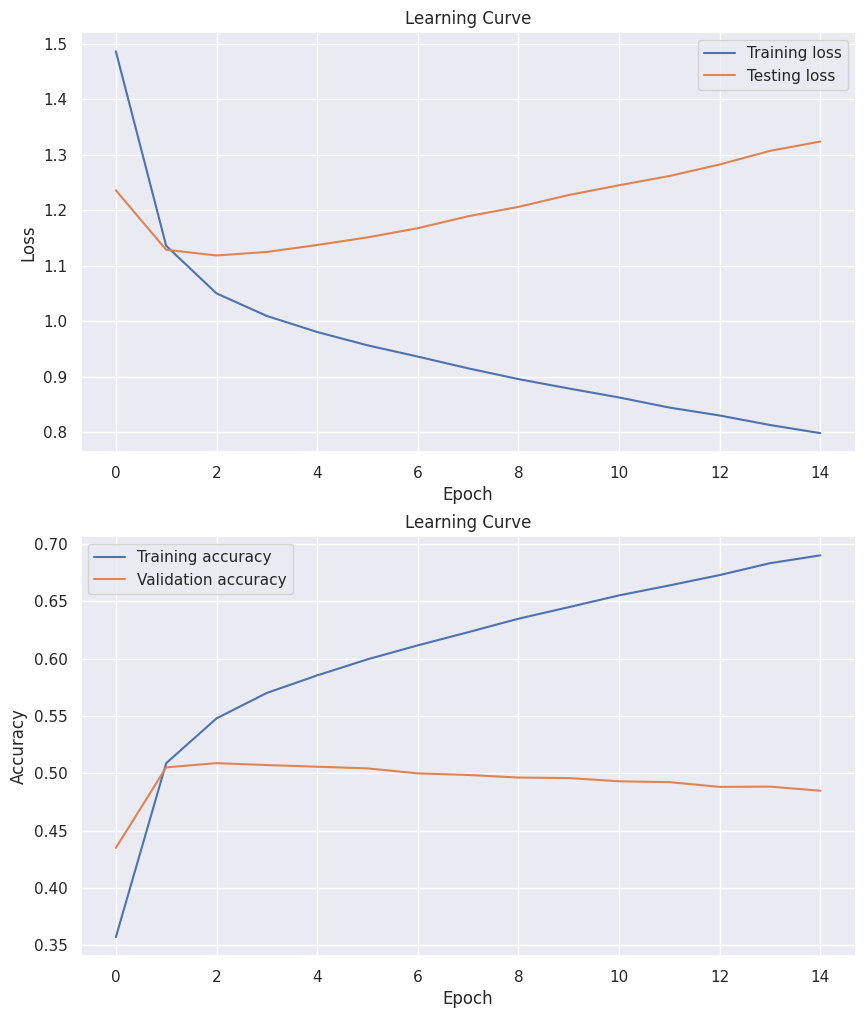

In [33]:
learning_curve(history2)

In [34]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

# flatten layer
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [35]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 32)            640000    
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_3 (Dense)             (None, 16)                25616     
                                                                 
 dense_4 (Dense)             (None, 5)                 85        
                                                                 
Total params: 665701 (2.54 MB)
Trainable params: 665701 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
history3 = model3.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

Epoch 1/15
120/120 - 4s - loss: 1.5271 - accuracy: 0.2969 - val_loss: 1.3409 - val_accuracy: 0.3960 - 4s/epoch - 30ms/step
Epoch 2/15
120/120 - 4s - loss: 1.2432 - accuracy: 0.4525 - val_loss: 1.1795 - val_accuracy: 0.4868 - 4s/epoch - 30ms/step
Epoch 3/15
120/120 - 3s - loss: 1.1122 - accuracy: 0.5227 - val_loss: 1.1194 - val_accuracy: 0.5084 - 3s/epoch - 22ms/step
Epoch 4/15
120/120 - 3s - loss: 1.0492 - accuracy: 0.5488 - val_loss: 1.1030 - val_accuracy: 0.5125 - 3s/epoch - 21ms/step
Epoch 5/15
120/120 - 3s - loss: 1.0104 - accuracy: 0.5675 - val_loss: 1.1013 - val_accuracy: 0.5137 - 3s/epoch - 21ms/step
Epoch 6/15
120/120 - 3s - loss: 0.9771 - accuracy: 0.5869 - val_loss: 1.1061 - val_accuracy: 0.5137 - 3s/epoch - 25ms/step
Epoch 7/15
120/120 - 3s - loss: 0.9436 - accuracy: 0.6081 - val_loss: 1.1125 - val_accuracy: 0.5126 - 3s/epoch - 28ms/step
Epoch 8/15
120/120 - 3s - loss: 0.9054 - accuracy: 0.6322 - val_loss: 1.1234 - val_accuracy: 0.5120 - 3s/epoch - 21ms/step
Epoch 9/15
120/1

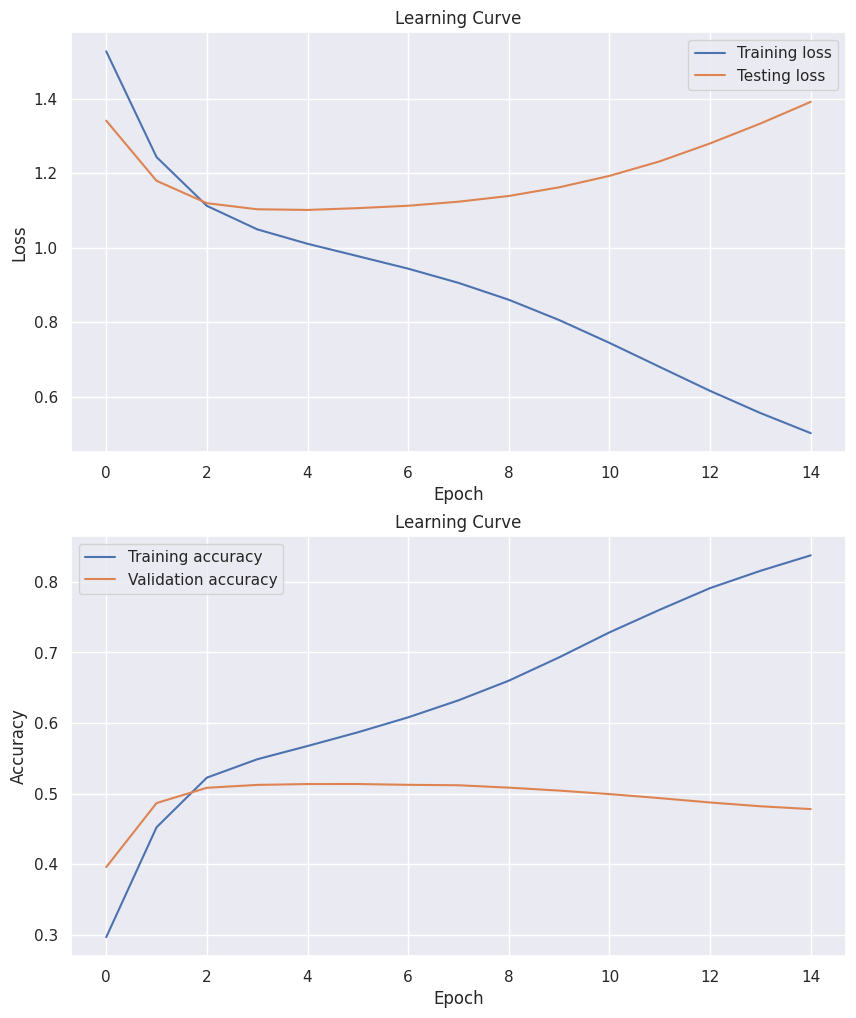

In [37]:
learning_curve(history3)

In [38]:
# model hyperparameters
embedding_dim = 16
num_epochs = 15
batch_size = 1000

# convolution
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='tanh'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(5, activation='softmax')
])
model4.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [39]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            320000    
                                                                 
 conv1d (Conv1D)             (None, 46, 128)           10368     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 331013 (1.26 MB)
Trainable params: 331013 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
history4 = model4.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

Epoch 1/15
120/120 - 18s - loss: 1.4362 - accuracy: 0.3710 - val_loss: 1.2030 - val_accuracy: 0.4638 - 18s/epoch - 147ms/step
Epoch 2/15
120/120 - 16s - loss: 1.1256 - accuracy: 0.5042 - val_loss: 1.1207 - val_accuracy: 0.5042 - 16s/epoch - 136ms/step
Epoch 3/15
120/120 - 16s - loss: 1.0550 - accuracy: 0.5384 - val_loss: 1.1059 - val_accuracy: 0.5113 - 16s/epoch - 136ms/step
Epoch 4/15
120/120 - 16s - loss: 1.0119 - accuracy: 0.5604 - val_loss: 1.1018 - val_accuracy: 0.5170 - 16s/epoch - 137ms/step
Epoch 5/15
120/120 - 16s - loss: 0.9758 - accuracy: 0.5806 - val_loss: 1.1066 - val_accuracy: 0.5156 - 16s/epoch - 137ms/step
Epoch 6/15
120/120 - 16s - loss: 0.9421 - accuracy: 0.6004 - val_loss: 1.1161 - val_accuracy: 0.5140 - 16s/epoch - 129ms/step
Epoch 7/15
120/120 - 16s - loss: 0.9101 - accuracy: 0.6171 - val_loss: 1.1308 - val_accuracy: 0.5118 - 16s/epoch - 130ms/step
Epoch 8/15
120/120 - 17s - loss: 0.8791 - accuracy: 0.6348 - val_loss: 1.1471 - val_accuracy: 0.5084 - 17s/epoch - 140

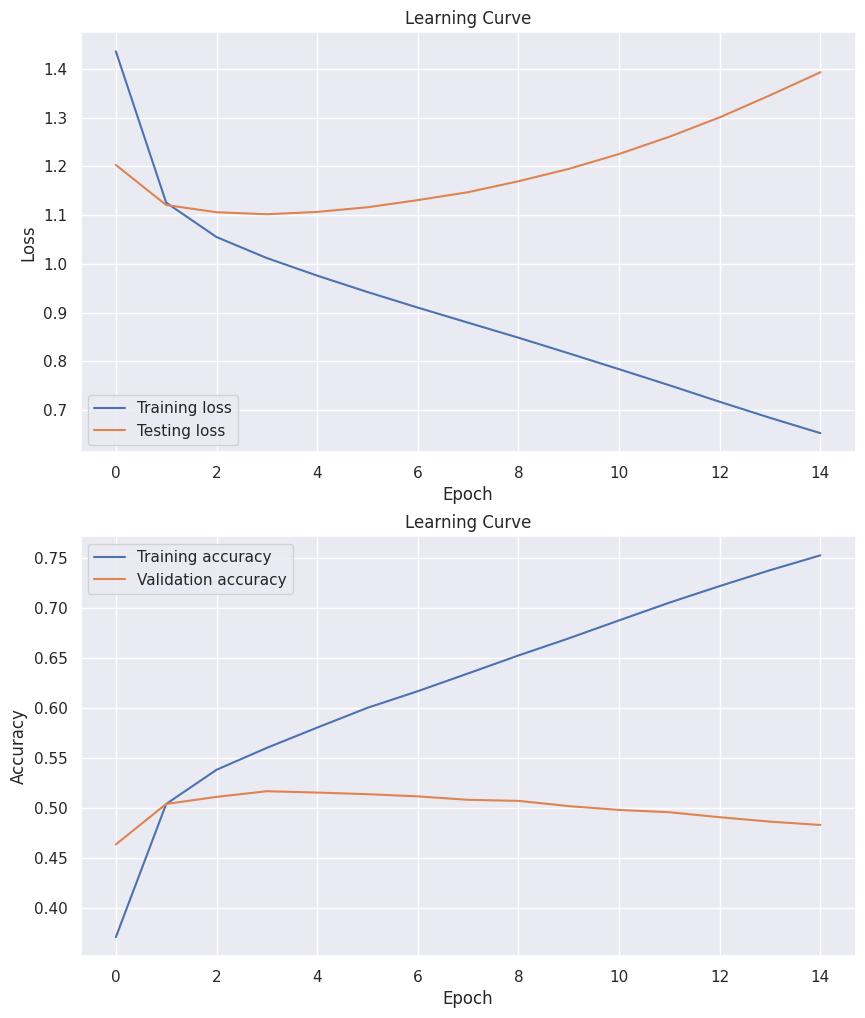

In [41]:
learning_curve(history4)

In [42]:
# model hyperparameters
embedding_dim = 16
num_epochs = 15
batch_size = 1000

# more complicated LSTM setup
model5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model5.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [43]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            320000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 50, 64)            12544     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
 dense_7 (Dense)             (None, 5)                 45        
                                                                 
Total params: 343221 (1.31 MB)
Trainable params: 34322

In [44]:
history5 = model5.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

Epoch 1/15
120/120 - 92s - loss: 1.4298 - accuracy: 0.3602 - val_loss: 1.1785 - val_accuracy: 0.4950 - 92s/epoch - 766ms/step
Epoch 2/15
120/120 - 75s - loss: 1.0991 - accuracy: 0.5273 - val_loss: 1.1163 - val_accuracy: 0.5074 - 75s/epoch - 625ms/step
Epoch 3/15
120/120 - 84s - loss: 1.0280 - accuracy: 0.5603 - val_loss: 1.1174 - val_accuracy: 0.5077 - 84s/epoch - 701ms/step
Epoch 4/15
120/120 - 81s - loss: 0.9923 - accuracy: 0.5809 - val_loss: 1.1348 - val_accuracy: 0.5024 - 81s/epoch - 676ms/step
Epoch 5/15
120/120 - 81s - loss: 0.9654 - accuracy: 0.5957 - val_loss: 1.1427 - val_accuracy: 0.5024 - 81s/epoch - 675ms/step
Epoch 6/15
120/120 - 82s - loss: 0.9376 - accuracy: 0.6114 - val_loss: 1.1652 - val_accuracy: 0.4990 - 82s/epoch - 686ms/step
Epoch 7/15
120/120 - 83s - loss: 0.9124 - accuracy: 0.6266 - val_loss: 1.1913 - val_accuracy: 0.4921 - 83s/epoch - 692ms/step
Epoch 8/15
120/120 - 83s - loss: 0.8883 - accuracy: 0.6410 - val_loss: 1.2131 - val_accuracy: 0.4926 - 83s/epoch - 696

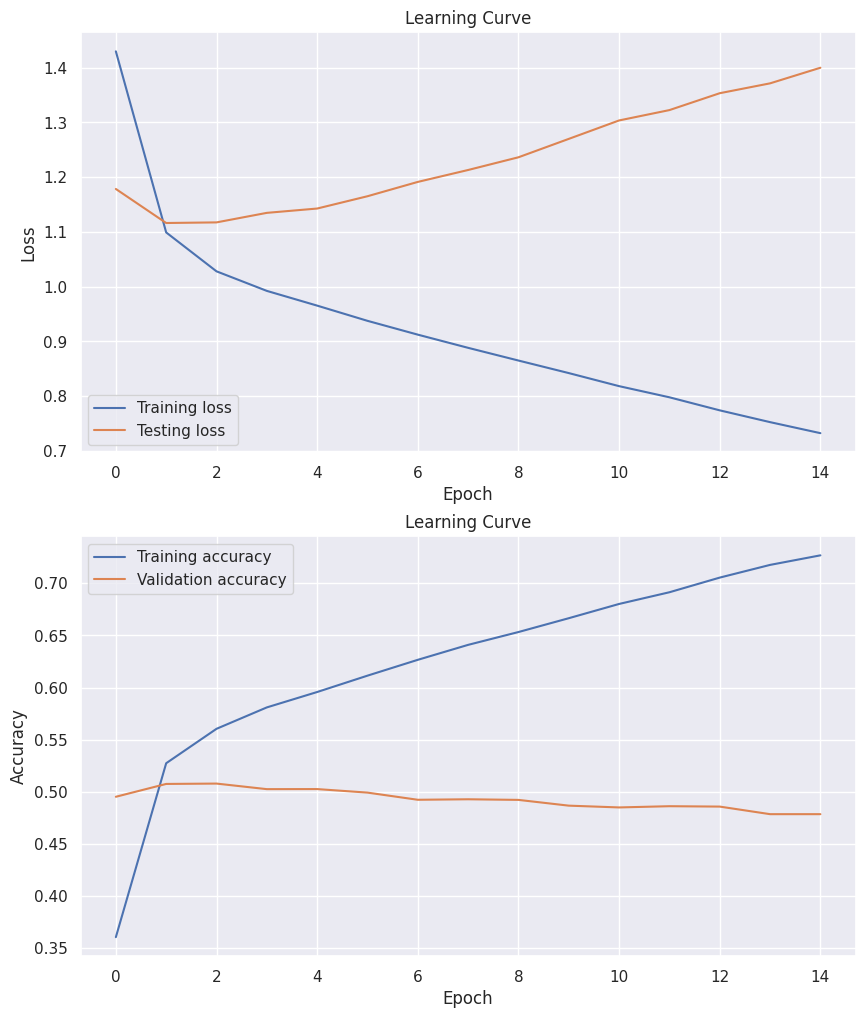

In [45]:
learning_curve(history5)

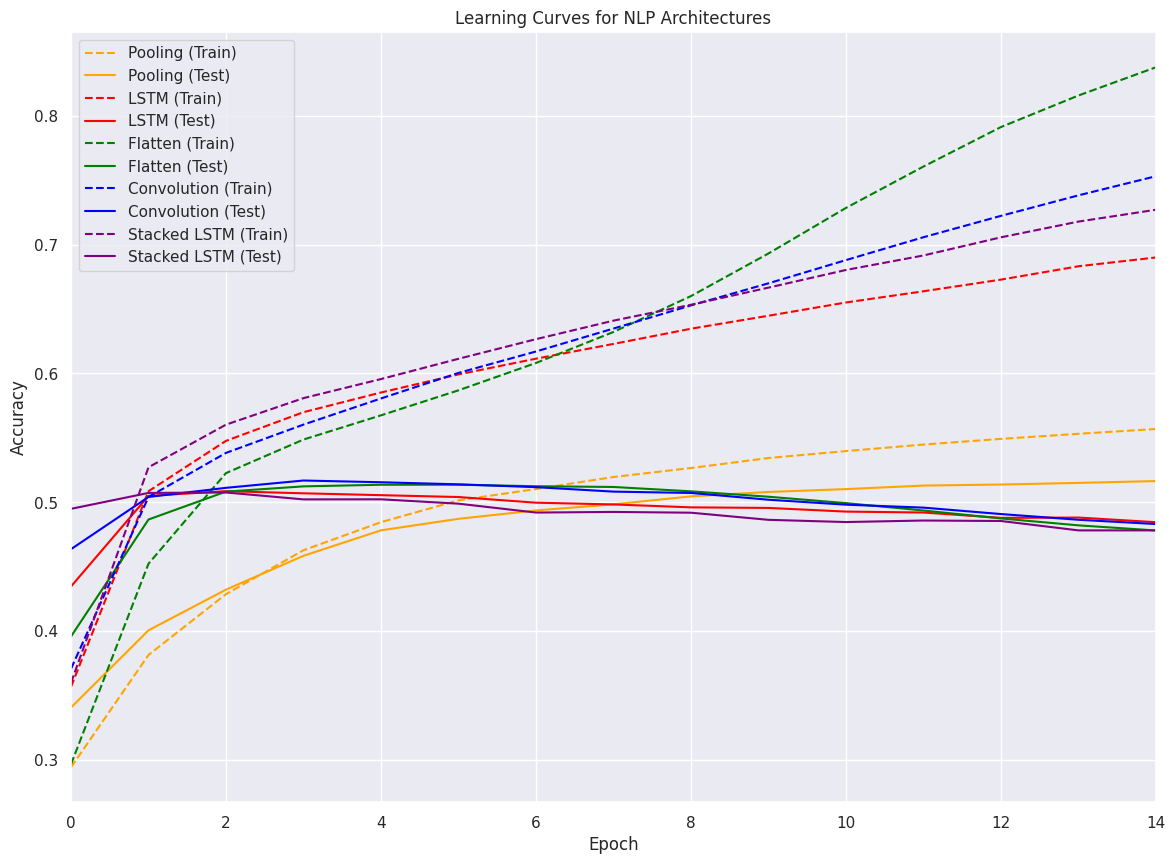

In [46]:
# Plot all five learning curves on the same axes.
plt.figure(figsize=(14,10))

# plt.axhline(0.33, label='Baseline', color='black')
plt.plot(history1.history['accuracy'], label='Pooling (Train)', color='orange', linestyle='dashed')
plt.plot(history1.history['val_accuracy'], label='Pooling (Test)', color='orange')
plt.plot(history2.history['accuracy'], label='LSTM (Train)', color='red', linestyle='dashed')
plt.plot(history2.history['val_accuracy'], label='LSTM (Test)', color='red')
plt.plot(history3.history['accuracy'], label='Flatten (Train)', color='green', linestyle='dashed')
plt.plot(history3.history['val_accuracy'], label='Flatten (Test)', color='green')
plt.plot(history4.history['accuracy'], label='Convolution (Train)', color='blue', linestyle='dashed')
plt.plot(history4.history['val_accuracy'], label='Convolution (Test)', color='blue')
plt.plot(history5.history['accuracy'], label='Stacked LSTM (Train)', color='purple', linestyle='dashed')
plt.plot(history5.history['val_accuracy'], label='Stacked LSTM (Test)', color='purple')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0,14)
#plt.ylim((0.5,0.8))
plt.title('Learning Curves for NLP Architectures')

plt.show()


In [ ]:
# # serialize model to JSON
# model_json = model5.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model5.save_weights("model.h5")
# print("Saved model to disk")

In [ ]:
# # code for loading json and creating model from the previously saved model data
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

# Confusion matrix analysis
---
We now examine the confusion matrices for some of the models to understand how classification is carried out.

In [47]:
from sklearn.metrics import confusion_matrix
import itertools

In [48]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalised confusion matrix")
  else:
    print("Confusion matrix without normalisation")

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j],
             horizontalalignment='center',
             color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
def confusion_matrix_complete(model, classes=['1', '2', '3', '4', '5'],
                              normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

  model_raw_predictions = model.predict(test_padded)
  model_rounded_predictions = np.argmax(model_raw_predictions, axis=-1)

  cm = confusion_matrix(y_true = test_labels, y_pred = model_rounded_predictions)

  plot_confusion_matrix(cm=cm, classes=classes, title=title)

In [50]:
sns.reset_orig()

1929/1929 [==============================] - 3s 1ms/step
Confusion matrix without normalisation
[[8248 2526  859  263  363]
 [4249 4643 2603  561  389]
 [1389 2301 4996 2697  949]
 [ 414  436 2031 5458 3840]
 [ 313  175  526 2943 8527]]


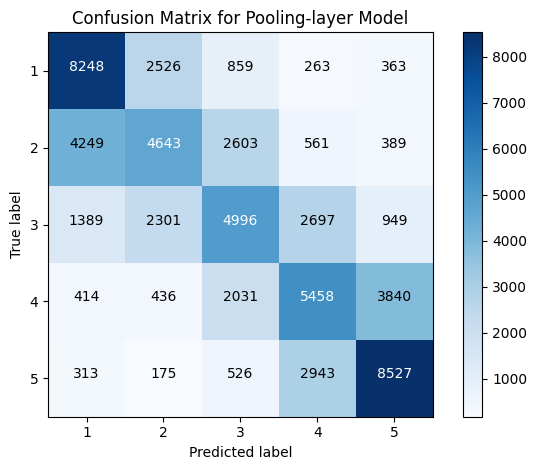

In [51]:
sns.reset_orig()
confusion_matrix_complete(model=model1, title='Confusion Matrix for Pooling-layer Model')

1929/1929 [==============================] - 17s 8ms/step
Confusion matrix without normalisation
[[7257 3366 1090  227  319]
 [3652 4852 3019  579  343]
 [1209 2521 5151 2640  811]
 [ 458  510 2581 5412 3218]
 [ 463  204  946 3639 7232]]


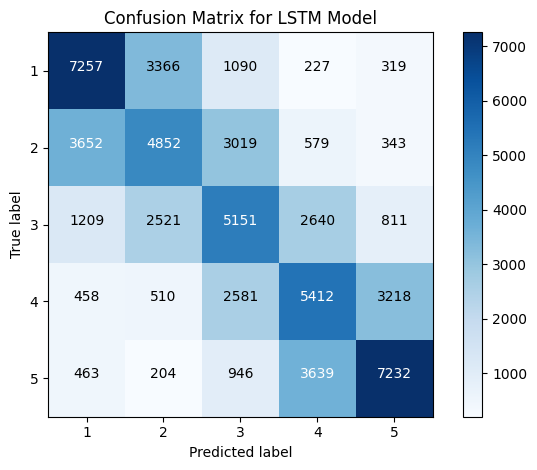

In [52]:
confusion_matrix_complete(model=model2, title='Confusion Matrix for LSTM Model')

1929/1929 [==============================] - 3s 2ms/step
Confusion matrix without normalisation
[[6988 3546 1044  310  371]
 [3606 5092 2597  659  491]
 [1297 2734 4550 2620 1131]
 [ 445  693 2033 5244 3764]
 [ 312  309  688 3542 7633]]


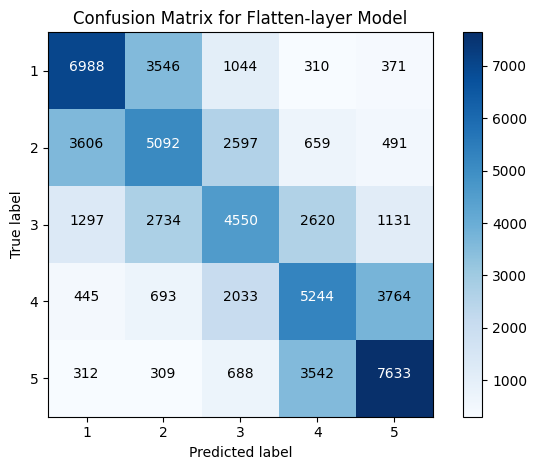

In [53]:
confusion_matrix_complete(model=model3, title='Confusion Matrix for Flatten-layer Model')

1929/1929 [==============================] - 7s 3ms/step
Confusion matrix without normalisation
[[7141 3177 1180  385  376]
 [3672 4738 2809  760  466]
 [1304 2297 5077 2651 1003]
 [ 424  578 2349 5282 3546]
 [ 345  295  895 3372 7577]]


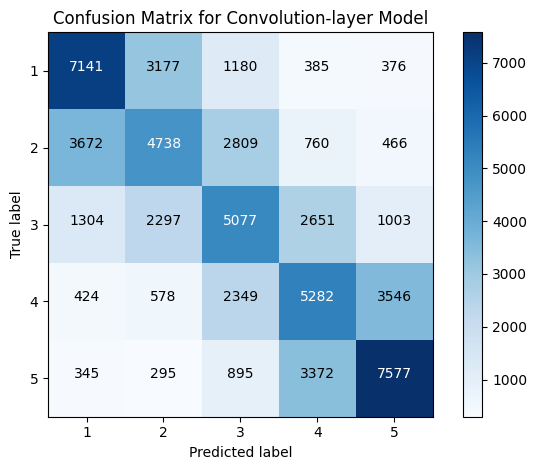

In [54]:
confusion_matrix_complete(model=model4, title='Confusion Matrix for Convolution-layer Model')

1929/1929 [==============================] - 40s 20ms/step
Confusion matrix without normalisation
[[7218 3294 1081  326  340]
 [3684 4959 2764  689  349]
 [1226 2789 5002 2434  881]
 [ 423  763 2486 5035 3472]
 [ 373  321  907 3585 7298]]


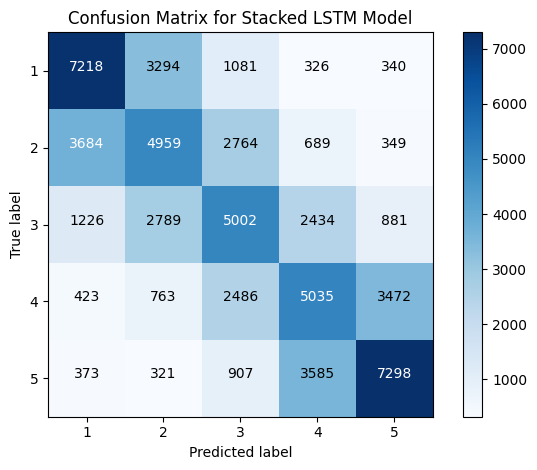

In [55]:
confusion_matrix_complete(model=model5, title='Confusion Matrix for Stacked LSTM Model')

## Misc
---

In [ ]:
model3_pred = model3.predict(test_padded)

1929/1929 [==============================] - 3s 2ms/step


In [ ]:
print(model3_pred[:20])

[[0.07189834 0.18311518 0.12035265 0.47595492 0.1486789 ]
 [0.10077157 0.1007635  0.09994294 0.2649706  0.43355143]
 [0.04191943 0.04364205 0.07291527 0.7138672  0.12765606]
 [0.10096794 0.12411005 0.11860839 0.2511275  0.40518618]
 [0.04517397 0.1298544  0.3573195  0.37166408 0.09598798]
 [0.10233922 0.10674406 0.09789838 0.25541985 0.43759844]
 [0.10172714 0.09856065 0.09638076 0.25911415 0.44421738]
 [0.10202479 0.1128969  0.10519776 0.25359347 0.4262871 ]
 [0.08616211 0.1670425  0.19432971 0.27138662 0.28107902]
 [0.10238191 0.10516708 0.0964863  0.25457582 0.44138876]
 [0.04034232 0.05970539 0.16305067 0.62536025 0.11154138]
 [0.05263908 0.41886225 0.31714988 0.13546742 0.07588142]
 [0.00835869 0.05283811 0.91675645 0.01096524 0.01108145]
 [0.01511372 0.810268   0.10912787 0.05837396 0.00711634]
 [0.10045527 0.12823062 0.12014349 0.25638163 0.39478904]
 [0.00740406 0.8601696  0.10193148 0.02852621 0.00196862]
 [0.10269476 0.10146155 0.09444891 0.2573143  0.44408053]
 [0.10151892 0

In [ ]:
model3_rounded_predictions = np.argmax(model3_pred, axis=-1)

In [ ]:
print(model3_rounded_predictions)

[3 4 3 ... 4 4 3]


In [ ]:
print(min(model3_rounded_predictions))

1
